In [6]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

In [7]:
data_dir = "../../../DATA_MAY18/spec1d/"
fname = '2-8h30m-270-spec1d.npy'

In [8]:
data = np.load(data_dir + fname) #object, flag (0, 1), wavelength. flags: 0 -> iamge, 1 -> ivar
data.shape

(143, 2, 5632)

In [4]:
print(data[0].shape)
print(data[0][0].shape)
print(len(data))

(2, 5632)
(5632,)
143


In [5]:
collapsedSpectrum = data[:, 0, :]
ivar = data[:, 1, :]

In [92]:
data['headers']

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [7]:
def Model(params, Amp = 1, std = 0.75): #Default, A = 1, std = 0.75
    """Returns the [OII] doublet model
    Parameters: Amp Amplitude
                params: tuple of spectra and lambda0 (centre point of the Model)
    """
    
    spectra, lambda0 = params
    Gaussian = lambda x, mean, std: np.exp(-((x - mean)/std)**2)
    
    #Values from http://classic.sdss.org/dr6/algorithms/linestable.html
    separation = (3729.875-3727.092)/2 #separation between lambda0 and the emission lines
    
    return Amp*(Gaussian(spectra, lambda0-separation, std) + Gaussian(spectra, lambda0+separation, std))

Text(0,0.5,'Flux Error')

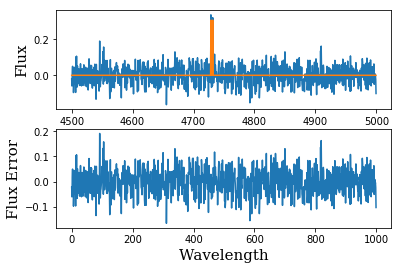

In [62]:
synthSpectra = np.arange(4500, 5000, .5) #Note that spacing must be geq the minimum linewidth, i.e. 0.1
pureData = Model((synthSpectra, 4730), 1, .1)
errstd = 0.05
errData = np.random.normal(0, errstd, synthSpectra.shape)
synthData = pureData + errData

plt.subplot(2,1,1)
plt.plot(synthSpectra, synthData)
plt.plot(synthSpectra, pureData)
plt.xlabel("Wavelength", fontname = 'serif', fontsize = 15)
plt.ylabel("Flux", fontname = 'serif', fontsize = 15)

plt.subplot(2,1,2)
plt.plot(errData)
plt.xlabel("Wavelength", fontname = 'serif', fontsize = 15)
plt.ylabel("Flux Error", fontname = 'serif', fontsize = 15)

In [63]:
def SNR_Calculatorv1(wavelength, flux, err):
    """Returns the SNR and lambda0 such that SNR is a function of lambda0
    Parameters: wavelength: array of wavelength range over which to test the filter
                flux: array of flux corresponding to the wavelength range
                err: array of flux error
                
    Returns: SNR: Signal-to-noise ratios of Amplitude
             lambda0: Different central values of the filter
    """
    
    lambda0_emitted = 3727.092 + (3729.875-3727.092)/2 #Midpoint of OII doublet
        
    #Initialise numpy arrays
    width = np.arange(0.1, 2.1, .1) #To calculate SNR at different linewidth
    z = np.zeros(len(wavelength))
    SNR = np.zeros((len(width), len(wavelength))) #width vs z grid
    dataPrime = flux/err #signal of data
    
    #Calculate SNR at different lambda0 and w
    for i in range(len(wavelength)):
        for j in range(len(width)):
            lambda0 = wavelength[i]
            modelFlux = Model((wavelength, lambda0), 1, width[j])
            modelPrime = modelFlux/err
            
            """A = (fluxPrime (dot) modelPrime)/(modelPrime (dot) modelPrime)
            sigmaA = 1/sqrt(modelPrime (dot) modelPrime)
            SNR = A/sigmaA"""
            sigmaA = 1./np.sqrt(np.dot(modelPrime, modelPrime))
            A = np.dot(dataPrime, modelPrime)/(sigmaA**(-2))
            SNR[j][i] = A/sigmaA
            
        #Convert lambda0 to z
        z[i] = lambda0/lambda0_emitted - 1
    
    return SNR, z, width

In [64]:
import time

In [72]:
t0 = time.time()
SNRv1, z, w = SNR_Calculatorv1(synthSpectra, synthData, errstd)
t1 = time.time()
totalv1 = t1-t0

In [69]:
def SNR_Calculatorv2(wavelength, flux, err):
    """Returns the SNR and lambda0 such that SNR is a function of lambda0
    Parameters: wavelength: array of wavelength range over which to test the filter
                flux: array of flux corresponding to the wavelength range
                err: array of flux error
                
    Returns: SNR: Signal-to-noise ratios of Amplitude
             lambda0: Different central values of the filter
    """
    
    lambda0_emitted = 3727.092 + (3729.875-3727.092)/2 #Midpoint of OII doublet
        
    #Initialise numpy arrays
    width = np.arange(0.1, 2.1, .1) #To calculate SNR at different linewidth
    z = np.zeros(len(wavelength))
    SNR = np.zeros((len(width), len(wavelength))) #width vs z grid
    dataPrime = flux/err #signal of data
    #Calculate SNR at different lambda0 and w
    for i in range(len(wavelength)-50): 
        #The window is 100 px wide with centre at the 50th px. Hence we go upto nth-50 such that we do not have index error
        for j in range(len(width)):
            lambda0 = wavelength[i+50]
            modelFlux = Model((wavelength[i:i+100], lambda0), 1, width[j])
            modelPrime = modelFlux/err
            
            """A = (fluxPrime (dot) modelPrime)/(modelPrime (dot) modelPrime)
            sigmaA = 1/sqrt(modelPrime (dot) modelPrime)
            SNR = A/sigmaA"""
            sigmaA = 1./np.sqrt(np.dot(modelPrime, modelPrime))
            A = np.dot(dataPrime[i:i+100], modelPrime)/(sigmaA**(-2))
            SNR[j][i] = A/sigmaA
            
        #Convert lambda0 to z
        z[i] = lambda0/lambda0_emitted - 1
    
    return SNR, z, width

In [73]:
t0 = time.time()
SNRv2, z, w = SNR_Calculatorv2(synthSpectra, synthData, errstd)
t1 = time.time()
totalv2 = t1-t0

In [74]:
print(totalv1)
print(totalv2)

11.849867343902588
2.1880805492401123


In [76]:
import seaborn as sns

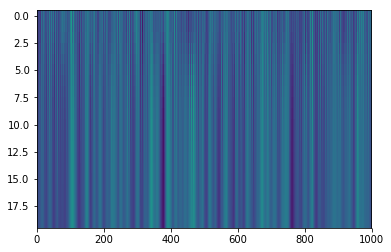

In [79]:
plt.imshow(SNRv1, aspect = 'auto')

In [81]:
np.where(SNRv1 == SNRv1.max())

(array([0], dtype=int64), array([460], dtype=int64))

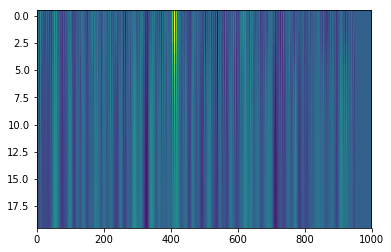

In [80]:
plt.imshow(SNRv2, aspect = 'auto')

In [82]:
np.where(SNRv2 == SNRv2.max())

(array([0], dtype=int64), array([410], dtype=int64))

In [83]:
SNRv2[0][410]

9.32342517135061

In [84]:
SNRv1[0][460]

9.32342517135061